# Using Reddit's API to Predict Number of Comments
*Connor Foley*, Data Science Immersive, General Assembly NYC, June 2018

In this project, I aimed to predict which features would predict whether or not a post on reddit makes it to the "hot" subreddit, which is a page for posts with high user interaction, as measured by the number of comments on the post. To gather the data, I scraped JSON post data from reddit's API and saved it to a .csv file. I set the target variable to a binarized measure of number of comments: above the mean amount of comments or below it.

I tried a few different kinds of models. Because there was text data and numerical data, I initially isolated them to look at how they performed on their own. A Logistic Regression model on only the numerical data gave me an accuracy score of 0.88, which is just short of the score for my best model. Using Count Vectorizer on the post title and running it through a Bernoulli Naïve Bayes model, I got a score that was about the same as the baseline. Hoping that a combination of these two initial approaches would give me a higher score, I used FeatureUnion to fit two pipelines inside a pipeline in order to combine text and numerical data. This resulted in a better score (0.91), but not as much as an improvement from the baseline as I had hoped for. Moving forward I would like to try both a regression model and a multi-class classification model.  

In [3]:
import requests
import json
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Step 1: Define the Problem
In this project, I am looking at the /hot subreddit of reddit.com, and building a model that accurately predicts whether or not a post will become "hot," having gained a high number of comments.

The target we are predicting is the number of comments a post has, which I binarized based on the mean. The required features for this project are subreddit name, post title, and time of post. However, I incorporated and created several other features I thought could be of importance.

### Step 2: Scrape Post Data from Reddit's API

In [ ]:
url = "http://www.reddit.com/hot.json"
headers = {'User-agent': 'Con bot 0.1'}
res = requests.get(url, headers=headers)
res.status_code

In [ ]:
reddit = res.json()
print(reddit.keys())
print(reddit['data'].keys())
print(reddit['kind'])

In [ ]:
## Brief exploration of the JSON
sorted(reddit['data']['children'][0]['data'].keys())

Here I pull multiple pages of post data, extract the JSON data, and store it in a list of dictionaries so that I can convert it into a DataFrame.

In [ ]:
print(reddit['data']['after'])
param = {'after': 't3_8mrd11'}

In [ ]:
posts = []
after = None
for i in range(168):
    if i % 12 == 0:
        print('{} of 168'.format(i)) 
    if after == None:
        params = {}
    else: 
        params = {'after': after}
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        reddit = res.json()
        posts.extend(reddit['data']['children'])
        after = reddit['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(3)

In [ ]:
len(set(p['data']['name'] for p in posts))

I pulled 4200 posts. The length above is 4045, meaning there are 155 duplicates.

Below I save everything I have scraped to `posts_df`, and then run a for loop to extract the data I know I will definitely need from the list of posts to a nice, cleaned DataFrame. I saved both to a .csv file as I went.

In [ ]:
posts_df = pd.DataFrame(posts)
posts_df.to_csv('./data/posts.csv')

In [ ]:
needed_data = []
for n in range(4200):
    post_dict = {}
    post_data = posts_df.iloc[n,0]
    post_dict['title'] = post_data['title']
    post_dict['subreddit'] = post_data['subreddit']
    post_dict['created_utc'] = post_data['created_utc']
    post_dict['num_comments'] = post_data['num_comments']
    needed_data.append(post_dict)

In [ ]:
needed = pd.DataFrame(needed_data)
needed.to_csv('./data/needed.csv')

### Step 3: Explore the Data
#### Load the .csv File
Here is where you may start running the cells.

In [4]:
posts_df = pd.read_csv('./data/posts.csv') 
posts_df.drop('Unnamed: 0', axis=1, inplace=True)
posts_df.head()

,data,kind
0,"{'is_crosspostable': False, 'subreddit_id': 't...",t3
1,"{'is_crosspostable': False, 'subreddit_id': 't...",t3
2,"{'is_crosspostable': False, 'subreddit_id': 't...",t3
3,"{'is_crosspostable': False, 'subreddit_id': 't...",t3
4,"{'is_crosspostable': False, 'subreddit_id': 't...",t3


Unfortunately, the way I saved the .csv for all the data I scraped resulted in my 'data' column containing the JSON dictionaries inside strings. Thankfully, there's a handy import called ast to fix this. I converted the strings into dictionaries and saved them to a list, in which I used a for loop to extract the extra features I wanted to include and add them to my already cleaned DataFrame of required data.

In [5]:
import ast

posts = posts_df['data']
for n in range(len(posts)):
    posts[n] = ast.literal_eval(posts[n])
type(posts[0])

dict

In [6]:
redd = pd.read_csv('./data/needed.csv') # My cleaned DF
redd.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
new_cols = ['num_crossposts', 'is_video', 'subreddit_subscribers', 'score', 'permalink']
other_data = []
for n in range(4200):
    post_dict = {}
    post_data = posts[n]
    for col in new_cols:
        post_dict[col] = post_data[col]
    other_data.append(post_dict)
    others_df = pd.DataFrame(other_data)
    reddit = pd.concat([redd, others_df], axis=1)

I included permalink in order to drop duplicate posts. By dropping them by the permalink column, I ensured I would not drop a false duplicate.

In [8]:
reddit.drop_duplicates('permalink', inplace=True)
print(reddit.shape)
reddit.drop('permalink', axis=1, inplace=True)

(4045, 9)


In [9]:
reddit['created_utc'] = time.time() - reddit['created_utc'] # Relative time

In [10]:
reddit.head()

,created_utc,num_comments,subreddit,title,is_video,num_crossposts,score,subreddit_subscribers
0,541880.459872,200,blackpeoplegifs,Destiny calls,False,4,14867,327189
1,544896.459872,3113,MemeEconomy,This format can work for a variety of things. ...,False,7,38179,534642
2,541610.459872,224,StarWars,So I got married last night...,False,1,12216,881134
3,543846.459872,1321,pics,This guy holding an umbrella over a soldier st...,False,6,32034,18677607
4,546286.459872,597,nostalgia,The family computer,False,1,25514,408323


#### Identify the Target
We want to create a binary target from the num_comments column. First, let's look at the distribution. It is incredibly skewed right, with most posts having a small number of comments.

The median is only 19, while the maximum value is 10,546 comments. The distribution is so heavily skewed that the 3rd quartile is less than the mean. 

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


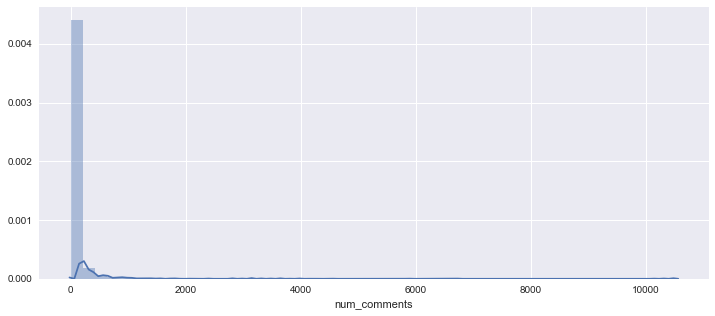

In [11]:
fix, ax = plt.subplots(figsize=(12,5))
sns.distplot(reddit['num_comments']);

In [12]:
reddit['num_comments'].describe()

count     4045.000000
mean        79.350309
std        323.166913
min          0.000000
25%          7.000000
50%         19.000000
75%         50.000000
max      10546.000000
Name: num_comments, dtype: float64

In [13]:
# There are some clear outliers:
print("Top ten largest values:", sorted(reddit['num_comments'])[-10:])

Top ten largest values: [3147, 3301, 3446, 3627, 3674, 3989, 4534, 5866, 6715, 10546]


In [14]:
# Create binary high comment target:
reddit['high_comment_mean'] = (reddit.num_comments > 79.35)*1
print("Baseline accuracy:", reddit.high_comment_mean.value_counts()[0]/len(reddit.high_comment_mean))

Baseline accuracy: 0.8286773794808405


#### Some Feature Engineering
I approached this with the assumption that many of the posts with the most amount of comments would come from a few of the same very popular subreddits, such as /r/pics. Therefore, I decided to use `get_dummies` on the subreddit column. 

To practice some additional feature engineering, I created two new columns out of the 'title' column: 
- A column in which the word "best" appears in the post title
- A column in which the first word is "when" (Considering one-liner memes such as _when the bass drops_)

In [15]:
best = []
for n in reddit.title:
    if "best" in n:
        best.append(1)
    elif "Best" in n:
        best.append(1)
    elif "BEST" in n:
        best.append(1)
    else:
        best.append(0)
reddit['best']=best

In [16]:
when = []
for n in reddit.title:
    if n[0:4]=="when":
        when.append(1)
    elif n[0:4]=="When":
        when.append(1)
    elif n[0:4]=="WHEN":
        when.append(1)
    else:
        when.append(0)
reddit['when'] = when

I created a DataFrame of strictly numerical data and removed the target.

In [17]:
subreddit_dummies = pd.get_dummies(reddit['subreddit'])
new_reddit = pd.concat([reddit, subreddit_dummies], axis=1)
new_reddit = new_reddit.drop(['subreddit','title','num_comments', 'high_comment_mean'], axis=1)
new_reddit['is_video'] = (new_reddit['is_video']==True).astype(int)
new_reddit.dtypes.value_counts() 

uint8      1987
int64         6
float64       1
dtype: int64

# Step 4: Model
With my DataFrame of strictly numerical data, i.e. all features except "title", I wanted to see how a Logistic Regression model would score.

#### Logistic Regression on Numerical Data

In [18]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(new_reddit, reddit['high_comment_mean'], random_state=24, stratify=reddit['high_comment_mean'])

In [19]:
ss = StandardScaler()
logreg = LogisticRegression(random_state=24)
pipe = Pipeline([('ss', ss),('logreg', logreg)])

In [20]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8784584980237155

In [21]:
# An improvement from the baseline
cross_val_score(pipe, X_test, y_test, cv=6).mean()

0.852820985248438

In [22]:
# GridSearch to find best parameters:
params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [.3,.4,.5,.6,.7,.8,.9,1.0]
}
gs = GridSearchCV(pipe, param_grid=params, scoring='accuracy')
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

0.8824110671936759

It is not worth including all the code, but trying a kNN Classifier model on the same features resulted in a worse score than the baseline on the test data, exhibiting a high level of overfitting on the training data.

#### Next Steps
I wanted to use some Natural Language Processing tools on the "title" column. However, creating a model using CountVectorizer and Bernoulli Naïve Bayes on "title" resulted in an accuracy score about the same as the baseline. Therefore, I wanted to try to create a model that combines my numerical data, which I used with the Logistic Regression model, with some Natural Language Processing.

The natural conclusion was to use FeatureUnion, nesting two pipelines within a pipeline. Using GridSearchCV, I reasoned that the combination of these models would give me an accuracy score significantly better than the baseline.

### MetaPipeline with FeatureUnion
Given that we have unbalanced classes in the target, I wanted to first try a model that will use bootstrapping: Random Forest Classifier.

In [69]:
X = pd.concat([new_reddit, reddit['title']], axis=1)
y = reddit['high_comment_mean']
cont_cols = [col for col in X.columns if col !='title']

In [70]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, random_state=24)

In [71]:
# Define a class to tell the pipeline which features to take
class DfExtract(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if len(self.column) > 1:
            return pd.DataFrame(X[self.column])
        else:
            return pd.Series(X[self.column[0]]) 

In [72]:
rf_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('post_title', Pipeline([
            ('text', DfExtract(['title'])),
            ('cvec', CountVectorizer(binary=True, stop_words='english')),
            ])),
        ('num_features', Pipeline([
            ('num_cols', DfExtract(cont_cols)),
            ('ss', StandardScaler())
        ])),
    ])),
    ('rf', RandomForestClassifier(random_state=24))
])

In [73]:
parameters = {
    'rf__n_estimators': [10,30,40,50,60],
    'rf__max_depth': [None,4,5],
    'rf__max_features': ['auto', 'log2', 15, 20]
}
rf_gs = GridSearchCV(rf_pipeline, param_grid=parameters, scoring='accuracy')

In [74]:
rf_gs.fit(X_train, y_train)
rf_gs.score(X_test, y_test)

0.8962450592885376

In [29]:
rf_gs.best_params_

{'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 40}

##### However...
Logistic Regression ended up giving me a slightly better score, despite the intuition that a bootstrapping model would make more sense for this kind of data.

In [30]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('post_title', Pipeline([
            ('text', DfExtract(['title'])),
            ('cvec', CountVectorizer(binary=True, stop_words='english')),
            ])),
        ('num_features', Pipeline([
            ('num_cols', DfExtract(cont_cols)),
            ('ss', StandardScaler())
        ])),
    ])),
    ('logreg', LogisticRegression(random_state=24))
])

In [31]:
parameters = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [.3,.4,.5,.6,.7,.8,.9,1.0],
}
gs = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy')

In [32]:
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

0.9051383399209486

In [33]:
gs.best_params_

{'logreg__C': 0.8, 'logreg__penalty': 'l1'}

# Step 5: Evaluate Model
The total scores from the classification report for both models are 0.88-0.91, which is about the same as the accuracy score. Also, given that the optimal penalty for the LogisticRegression model was Lasso, we can conclude that there were irrelevant features in the model.

Given that there were unbalanced classes in the target variable, I wanted to include a model that would bootstrap data from an underrepresented class, hence trying RandomForest and LogisticRegression. Both gave around the same score, with LogisticRegression performing slightly better. 

In [148]:
# Classification Report for Random Forest:
rf_predictions = rf_gs.predict(X_test)
print(classification_report(y_test, rf_predictions, target_names=['Low Comments', 'High Comments']))

               precision    recall  f1-score   support

 Low Comments       0.90      0.99      0.94       845
High Comments       0.87      0.44      0.58       167

  avg / total       0.89      0.90      0.88      1012



In [149]:
# Classification Report for Logistic Regression:
predictions = gs.predict(X_test)
print(classification_report(y_test, predictions, target_names=['Low Comments', 'High Comments']))

               precision    recall  f1-score   support

 Low Comments       0.93      0.96      0.94       845
High Comments       0.76      0.62      0.68       167

  avg / total       0.90      0.91      0.90      1012



I used a function from scikitlearn's documentation on confusion matrices to plot one:
_This is for the Logistic Regression model._

Confusion matrix, without normalization
[[812  33]
 [ 63 104]]
Normalized confusion matrix
[[0.96 0.04]
 [0.38 0.62]]


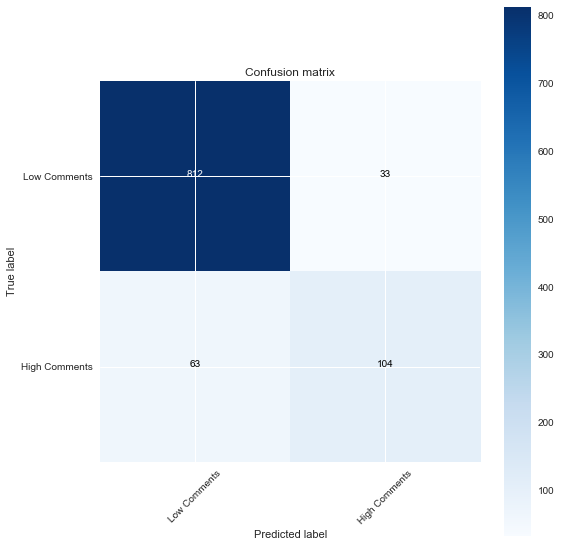

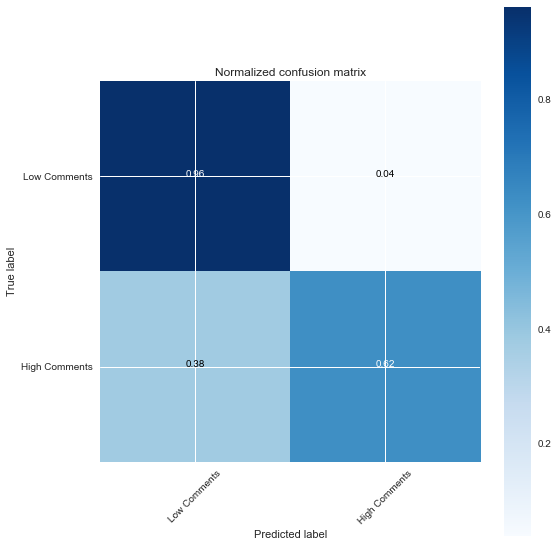

In [35]:
import itertools

# From ScikitLearn's documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Low Comments','High Comments'],
                      title='Confusion matrix')

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Low Comments','High Comments'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Step 6: Answer the Question
#### Interpreting the Feature Importances
The models I chose are extremely difficult to interpret. Seeing as how the model only improved by 0.1 from the baseline, I didn't expect to see any very high coefficients. The highest from the RandomForest model are in the thousandth decimal range or lower, and they are all dummies of subreddits. 

In [97]:
rf_feats = pd.DataFrame(
    list(
        zip(X_test.columns, np.abs(
            rf_gs.best_estimator_.steps[1][1].feature_importances_))), columns=['feature','coef_abs'])


In [100]:
rf_feats = rf_coefs.sort_values('coef_abs', ascending=False)
rf_feats.head(10)
# These are all subreddit dummies

,feature,coef_abs
536,Lovecraft,0.001057
196,Catloaf,0.001040
1715,robotics,0.001030
891,Torontobluejays,0.001023
1177,crossdressing,0.001020
586,MilitaryPorn,0.001007
661,OutOfTheLoop,0.001002
156,Braves,0.000967
1252,entwives,0.000939
187,CanadianForces,0.000917


In [156]:
lr_coef_list = gs.best_estimator_.steps[1][1].coef_[0]

In [157]:
lr_coefs = pd.DataFrame(
    list(
        zip(X_test.columns, np.abs(
            lr_coef_list))), columns=['feature','coef_abs'])
lr_coefs.sort_values('coef_abs', ascending=False, inplace=True)

In [158]:
lr_coefs[abs(lr_coefs['coef_abs']) > 0]

,feature,coef_abs


### Conclusions
Though the models have around 90% accuracy, I was hoping for a greater improvement from the baseline. The number of comments on a reddit post inevitably comes down to human activity, which is inherently unpredictable. Were I to create a classification model for this problem again, I would have created more than one class for number of comments. Based on the extremely skewed distribution of number of comments, it would have been prudent to create a "low comment" class, a "high comment" class, and a "ultra-high comment" class. Likewise, although the purpose of this project was to use a classification model, a regression analysis would have made sense as well. 